In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
ticker = 'bbl.bk'
data = yf.Ticker(ticker)
print(data.info)

currentprice = data.info['currentPrice']
sector = data.info['sector']
print(currentprice)
print(sector)

dr = 0.10
gr = 0.10
tgr = 0.03
year_growth = 3
year_sustain = 7
growth_to_sustain_ratio = 0.5

{'address1': '333 Silom Road', 'address2': 'Bangrak', 'city': 'Bangkok', 'zip': '10500', 'country': 'Thailand', 'phone': '66 2 645 5555', 'fax': '66 2 231 4890', 'website': 'https://www.bangkokbank.com', 'industry': 'Banks - Regional', 'industryKey': 'banks-regional', 'industryDisp': 'Banks - Regional', 'sector': 'Financial Services', 'sectorKey': 'financial-services', 'sectorDisp': 'Financial Services', 'longBusinessSummary': "Bangkok Bank Public Company Limited provides various commercial banking products and services in Thailand and internationally. It operates through Domestic Banking, International Banking, Investment Banking, and Others segments. The company offers various personal banking products and services, including savings, current, fixed deposit, foreign currency, securities trading, and other accounts; home and personal loans, as well as loans for pensioners; mutual funds; bonds and debentures; life and non-life bancassurance products; payment, funds transfer, currency e

In [3]:
# data.cash_flow.index

In [4]:
### - get > Average Free cash flow , shares , Net Debt = Long Term Borrowings - Cash ###

## Shares ## 
shares = data.info['sharesOutstanding']
print('Ticker = ',ticker,' Shares = ',shares)

## Net Debt = Long Term Borrowings - Cash ###
if sector == 'Financial Services':
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Net Debt'].values[0][0]
else:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Total Non Current Liabilities Net Minority Interest'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]

print('Ticker = ',ticker,' Net Debt = ',totalnoncurrentliabilities)

## Average Free Cash Flow ## 
year = 4
if sector == 'Financial Services':
    averagefreecashflow = (data.cash_flow.T['Free Cash Flow'] + data.cash_flow.T['Repayment Of Debt']).dropna()[:year].mean()
    print((data.cash_flow.T['Free Cash Flow'] + data.cash_flow.T['Repayment Of Debt']).dropna()[:year])
else:
    averagefreecashflow = data.cash_flow.T['Free Cash Flow'].dropna()[:year].mean()
    print(data.cash_flow.T['Free Cash Flow'].dropna()[:year])


print('Ticker = ',ticker,'Average Free Cash Flow = ',averagefreecashflow)

Ticker =  bbl.bk  Shares =  1908839936
Ticker =  bbl.bk  Net Debt =  473061020000.0
2023-12-31     90668273000.0
2022-12-31     38661909000.0
2021-12-31     -5706898000.0
2020-12-31    185893037000.0
dtype: object
Ticker =  bbl.bk Average Free Cash Flow =  77379080250.0


In [5]:
##### Create a DCF Function ######

def intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    return (np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares

print(ticker + ' Intrinsic Value = ',
      np.round(intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ),2))

bbl.bk Intrinsic Value =  541.08


In [6]:
### Put current price as a target ### 

def intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    # print((((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares)) , currentprice)
    return (((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares) - currentprice)/currentprice

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        0.15
        )*100," % ")

418.02841659226686  % 


In [7]:
def newton_raphson_method(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice):
    
    initial_guess = 0.01
    tolerance = 0.01
    max_iterations = 100000
    x_n = initial_guess
    
    for iteration in range(max_iterations):
    # while (True):
        f_x = intrinsic_value_diff_currentprice(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice,
            x_n
        )

        if abs(f_x) < tolerance :
            break

        x_n = x_n - f_x * 0.01

    return x_n

In [8]:
root = newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice)

print("Estimated GR:", root)

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        root
        ) * 100," % ")


Estimated GR: -0.037766822910064536
0.986727582542387  % 


      growthrate
0.04   -0.304677
0.05   -0.222092
0.06   -0.168898
0.07   -0.128137
0.08   -0.094148
...          ...
0.96    1.245111
0.97    1.258624
0.98    1.272131
0.99    1.285633
1.00    1.299230

[97 rows x 1 columns]
1.4886197115688349 -0.15511811874240938


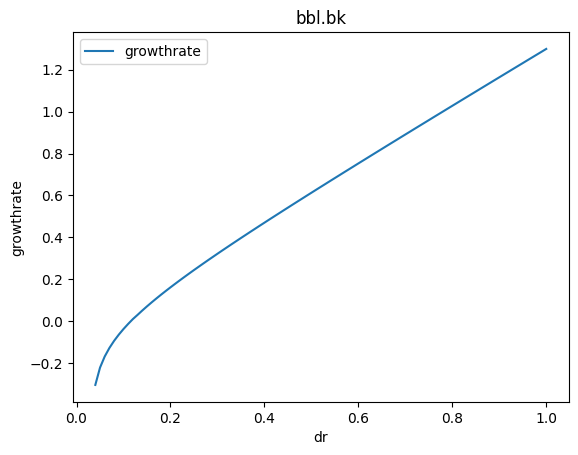

In [9]:
dr_list = [dr*0.01 for dr in range(int((tgr*100)+1),101,1)]
df = pd.DataFrame(index=dr_list,columns=['growthrate'])

growthrate = [ newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice) for dr in dr_list]
df['growthrate'] = growthrate
print(df)
df.plot(xlabel='dr', ylabel='growthrate').set_title(ticker)

beta, alpha = np.polyfit(np.array(df.index).astype('float64'), np.array(df['growthrate']).astype('float64'),1)
print(beta,alpha)